In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], False)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

In [3]:
#Definir rutas de las carétas que contienen las imágenes
directorio = "../../../imagenes/mexh/"
img_width, img_height = 250, 250
input_shape = (img_width, img_height, 3)

#Hiperparámetros
epochs =50
batch_size = 32

In [4]:
# Configurar el generador de datos de imágenes
generador_datos = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Cargar y dividir los datos en conjuntos de entrenamiento y prueba
generador_entrenamiento = generador_datos.flow_from_directory(
    directorio,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

generador_validacion = generador_datos.flow_from_directory(
    directorio,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [24]:
# Definir el modelo CNN
clasificador = Sequential()

clasificador.add(Conv2D(128, (3, 3), input_shape=input_shape, activation='relu'))
clasificador.add(MaxPooling2D(pool_size=(5,5)))
clasificador.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
clasificador.add(MaxPooling2D(pool_size=(5,5)))
clasificador.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
clasificador.add(MaxPooling2D(pool_size=(5,5)))


# Capa de aplanamiento
clasificador.add(Flatten())

# Se agregan las capas densas
clasificador.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.001)))
clasificador.add(Dropout(rate=0.5))

# Capa de salida
clasificador.add(Dense(units=1, activation='sigmoid'))

In [25]:
# Compilar el modelo
clasificador.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

# Entrenar el modelo
history = clasificador.fit(
    generador_entrenamiento,
    steps_per_epoch=generador_entrenamiento.samples // batch_size,
    epochs=epochs,
    validation_data=generador_validacion,
    validation_steps=generador_validacion.samples // batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.6025
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to modelo_generado\mejor_modelo.keras
100/100 [==============================] - 14s 120ms/step - loss: 0.8669 - accuracy: 0.6025 - val_loss: 0.6982 - val_accuracy: 0.6125
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.6484
Epoch 2: val_accuracy improved from 0.61250 to 0.65125, saving model to modelo_generado\mejor_modelo.keras
100/100 [==============================] - 12s 119ms/step - loss: 0.6618 - accuracy: 0.6484 - val_loss: 0.6423 - val_accuracy: 0.6513
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6672
Epoch 3: val_accuracy did not improve from 0.65125
100/100 [==============================] - 11s 114ms/step - loss: 0.6385 - accuracy: 0.6672 - val_loss: 0.6427 - val_accuracy: 0.6413
Epoch 4/50
100/100 [============================

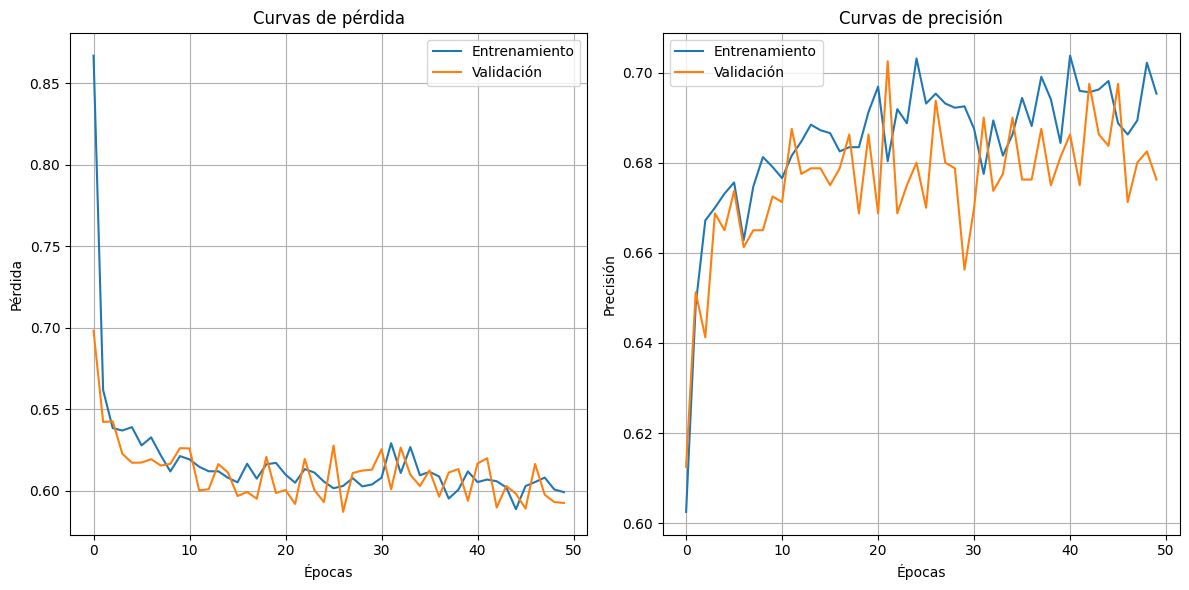

In [27]:
# Graficar las curvas de pérdida y precisión durante el entrenamiento y la validación
plt.figure(figsize=(12, 6))

# Curvas de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curvas de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

# Curvas de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Curvas de precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()